In [1]:
# Required packages to run the script
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticke
import seaborn as sns

from matplotlib.colors import LogNorm
import math
import os
import pickle as pkl
from scipy import sparse
from scipy.sparse.linalg import lsqr
import scipy.fftpack
import xlsxwriter
import importlib
import plotly.express as px
import plotly.graph_objects as go
import glob

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import os

In [2]:
import sys
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, 's:\\131-DPE\\131.1-Temporaire\\131.1.1-Espace commun\\zone transfert temporaire\\ITESE Grenoble\\Stage Justine\\Code git\\wavelet_decomposition')
from wavelet_decomposition import reconstruct

In [3]:
path_input_data = '../input_time_series/'
dpd = 24 # data per day in the time serie
dpy = 365 # data per year :  cut the leap years to 365 years

ndpd = 64 # new data per day for hourly data (for the interpolation)
signal_length = ndpd * dpy

# Chargement des caractéristiques des signaux

In [4]:
result_optim = pd.read_pickle(f'results/France/optimization_results.pickle')
result_optim['pv_capacity']

148914.25179778694

In [5]:
import seaborn as sn
from scipy.stats import pearsonr
list_lags = pd.read_csv("results/lags_world_diff_true.csv", index_col=0)

for country_name in list_lags.index[:] :
    try :
        result_optim = pd.read_pickle(f'results/{country_name}/optimization_results.pickle')
        list_lags.loc[country_name,'share_wind'] = result_optim['share_wind']
        list_lags.loc[country_name,'share_pv'] = result_optim['share_pv']
        list_lags.loc[country_name,'share_dispatch'] = result_optim['share_dispatchable']
        list_lags.loc[country_name, 'cf_pv']=np.min(result_optim['cf_pv'])
        list_lags.loc[country_name, 'cf_wind'] = np.min(result_optim['cf_wind'])
        # list_lags.loc[country_name, 'Pmin/Pmax PV'] = np.min(result_optim['optimized_pv'])/np.max(result_optim['optimized_pv'])
        # list_lags.loc[country_name, 'Pmin/Pmax Wind'] = np.min(result_optim['optimized_wind'])/np.max(result_optim['optimized_wind'])
        # list_lags.loc[country_name, 'Pmin/Pmax Load'] = np.min(result_optim['consumption'])/np.max(result_optim['consumption'])
        # list_lags.loc[country_name, 'Max Diff Wind/D']= np.max(result_optim['consumption']-result_optim['optimized_wind'])
        # list_lags.loc[country_name, 'Mean Diff Wind/D']= np.mean(result_optim['consumption']-result_optim['optimized_wind'])
        list_lags.loc[country_name, 'corr_load_wind']= pearsonr(result_optim['consumption'], result_optim['optimized_wind'])[0]
        list_lags.loc[country_name, 'corr_load_pv']= pearsonr(result_optim['consumption'], result_optim['optimized_pv'])[0]
        # Les résultats des décompositions pour chaque signal de conso et de production ont été calculés et sont stcokés dans
        # un fichier .pickle par pays.
        data_wavelets = pd.read_pickle( f'results_decomposition_coefficient/Plexos/wavelets_reconstruction/wavelets_{country_name}.pickle')
        # LOAD
        list_lags.loc[country_name, 'beta_year_load'] = np.max(data_wavelets['load_year'])
        list_lags.loc[country_name, 'max_beta_week_load'] = np.max(data_wavelets['load_week'])
        list_lags.loc[country_name, 'max_beta_day_load'] = np.max(data_wavelets['load_day'])
        pv_week = data_wavelets['load_week']
        pv_week = pv_week[pv_week>0]
        list_lags.loc[country_name, 'mean_beta_week_load'] = np.mean(data_wavelets['load_week'][data_wavelets['load_week']>0])
        list_lags.loc[country_name, 'mean_beta_day_load'] = np.mean(data_wavelets['load_day'][data_wavelets['load_day']>0])

        # PV
        list_lags.loc[country_name, 'beta_year_pv'] = np.max(data_wavelets['pv_year'])
        list_lags.loc[country_name, 'max_beta_week_pv'] = np.max(data_wavelets['pv_week'])
        list_lags.loc[country_name, 'max_beta_day_pv'] = np.max(data_wavelets['pv_day'])
        list_lags.loc[country_name, 'mean_beta_week_pv'] = np.mean(data_wavelets['pv_week'][data_wavelets['pv_week']>0])
        list_lags.loc[country_name, 'mean_beta_day_pv'] = np.mean(data_wavelets['pv_day'][data_wavelets['pv_day']>0])

        # WIND
        list_lags.loc[country_name, 'beta_year_wind'] = np.max(data_wavelets['wind_year'])
        list_lags.loc[country_name, 'max_beta_week_wind'] = np.max(data_wavelets['wind_week'])
        list_lags.loc[country_name, 'max_beta_day_wind'] = np.max(data_wavelets['wind_day'])
        list_lags.loc[country_name, 'mean_beta_week_wind'] = np.mean(data_wavelets['wind_week'][data_wavelets['wind_week']>0])
        list_lags.loc[country_name, 'mean_beta_day_wind'] = np.mean(data_wavelets['wind_day'][data_wavelets['wind_day']>0])

        # SCALAR PRODUCTS
        list_lags.loc[country_name, 'scalar_year_pv_load'] = np.max(data_wavelets['scalar_year_pv_load'])
        list_lags.loc[country_name, 'scalar_year_wind_load'] = np.max(data_wavelets['scalar_year_wind_load'])
        list_lags.loc[country_name, 'scalar_day_pv_load'] = np.max(data_wavelets['scalar_day_pv_load'])
        list_lags.loc[country_name, 'scalar_day_wind_load'] = np.mean(data_wavelets['scalar_day_wind_load'])
        list_lags.loc[country_name, 'scalar_week_pv_load'] = np.mean(data_wavelets['scalar_week_pv_load'])
        list_lags.loc[country_name, 'scalar_week_wind_load'] = np.mean(data_wavelets['scalar_week_pv_load'])

        # WEIGHT TS
        list_lags.loc[country_name, 'weight_pv'] = result_optim['pv_capacity']/result_optim['mean_consumption']
        list_lags.loc[country_name, 'weight_wind'] = result_optim['wind_capacity']/result_optim['mean_consumption']

    except Exception as e:
        print(f"Error processing {country_name}: {e}")

list_lags.to_csv("results/predictors_regression_country.csv")

Error processing Antarctica: 'share_wind'
Error processing Dominican Republic: 'share_wind'
Error processing Rwanda: 'share_wind'
Error processing Swaziland: 'share_wind'
Error processing Syrian Arab Republic: 'share_wind'
Error processing Turkmenistan: 'share_wind'
Error processing United Arab Emirates: 'share_wind'
Error processing Western Sahara: 'share_wind'


In [334]:
# data_wavelets = pd.read_pickle( f'results_decomposition_coefficient/Plexos/wavelets_reconstruction/wavelets_France.pickle')
# pv_week = data_wavelets['pv_week'][data_wavelets['pv_week']>0]
# positive_values = pv_week[pv_week>0]
# np.mean(positive_values)

In [335]:
import seaborn as sn
from scipy.stats import pearsonr
list_lags_states = pd.read_csv("results/lags_world_diff_states_3.csv").drop_duplicates()
regions_match = pd.read_excel('match_plexos_iso_codes.xlsx', index_col=1)

list_lags_states = list_lags_states.set_index(['Country', 'State'])
list_lags_states = list_lags_states.sort_index()
for country, state_name in list_lags_states.index :
    regions_match_country = regions_match[regions_match['Country']==country]
    # print(country, state_name)

    region_name = regions_match_country.loc[state_name, 'plexos']
    # print(region_name)
    try :
        result_optim = pd.read_pickle(f'results/{country}/optimization_results_{state_name}.pickle')
        # print(list_lags_states.loc[(country, state_name),'share_wind'])
        list_lags_states.loc[(country, state_name),'share_wind'] = result_optim['share_wind']
        # print(list_lags_states.loc[(country, state_name),'share_wind'])
        list_lags_states.loc[(country, state_name),'share_pv'] = result_optim['share_pv']
        list_lags_states.loc[(country, state_name),'share_dispatch'] = result_optim['share_dispatchable']
        list_lags_states.loc[(country, state_name), 'cf_pv']=np.min(result_optim['cf_pv'])
        list_lags_states.loc[(country, state_name), 'cf_wind'] = np.min(result_optim['cf_wind'])
    
        list_lags_states.loc[(country, state_name), 'corr_load_wind']= pearsonr(result_optim['consumption'], result_optim['optimized_wind'])[0]
        list_lags_states.loc[(country, state_name), 'corr_load_pv']= pearsonr(result_optim['consumption'], result_optim['optimized_pv'])[0]
        # Les résultats des décompositions pour chaque signal de conso et de production ont été calculés et sont stcokés dans
        # un fichier .pickle par pays.
        # print('Now wavelets...')
        data_wavelets = pd.read_pickle( f'results_decomposition_coefficient/Plexos/wavelets_reconstruction/wavelets_{country}_{state_name}.pickle')
       # LOAD
        list_lags_states.loc[(country, state_name), 'beta_year_load'] = np.max(data_wavelets['load_year'])
        list_lags_states.loc[(country, state_name), 'max_beta_week_load'] = np.max(data_wavelets['load_week'])
        list_lags_states.loc[(country, state_name), 'max_beta_day_load'] = np.max(data_wavelets['load_day'])
    
        list_lags_states.loc[(country, state_name), 'mean_beta_week_load'] = np.mean(data_wavelets['load_week'][data_wavelets['load_week']>0])
        list_lags_states.loc[(country, state_name), 'mean_beta_day_load'] = np.mean(data_wavelets['load_day'][data_wavelets['load_day']>0])

        # PV
        list_lags_states.loc[(country, state_name), 'beta_year_pv'] = np.max(data_wavelets['pv_year'])
        list_lags_states.loc[(country, state_name), 'max_beta_week_pv'] = np.max(data_wavelets['pv_week'])
        list_lags_states.loc[(country, state_name), 'max_beta_day_pv'] = np.max(data_wavelets['pv_day'])
        list_lags_states.loc[(country, state_name), 'mean_beta_week_pv'] = np.mean(data_wavelets['pv_week'][data_wavelets['pv_week']>0])
        list_lags_states.loc[(country, state_name), 'mean_beta_day_pv'] = np.mean(data_wavelets['pv_day'][data_wavelets['pv_day']>0])

        # WIND
        list_lags_states.loc[(country, state_name), 'beta_year_wind'] = np.max(data_wavelets['wind_year'])
        list_lags_states.loc[(country, state_name), 'max_beta_week_wind'] = np.max(data_wavelets['wind_week'])
        list_lags_states.loc[(country, state_name), 'max_beta_day_wind'] = np.max(data_wavelets['wind_day'])
        list_lags_states.loc[(country, state_name), 'mean_beta_week_wind'] = np.mean(data_wavelets['wind_week'][data_wavelets['wind_week']>0])
        list_lags_states.loc[(country, state_name), 'mean_beta_day_wind'] = np.mean(data_wavelets['wind_day'][data_wavelets['wind_day']>0])
        # SCALAR PRODUCTS
        list_lags_states.loc[(country, state_name), 'scalar_year_pv_load'] = np.max(data_wavelets['scalar_year_pv_load'])
        list_lags_states.loc[(country, state_name), 'scalar_year_wind_load'] = np.max(data_wavelets['scalar_year_wind_load'])
        list_lags_states.loc[(country, state_name), 'scalar_day_pv_load'] = np.max(data_wavelets['scalar_day_pv_load'])
        list_lags_states.loc[(country, state_name), 'scalar_day_wind_load'] = np.mean(data_wavelets['scalar_day_wind_load'])
        list_lags_states.loc[(country, state_name), 'scalar_week_pv_load'] = np.mean(data_wavelets['scalar_week_pv_load'])
        list_lags_states.loc[(country, state_name), 'scalar_week_wind_load'] = np.mean(data_wavelets['scalar_week_wind_load'])

        # WEIGHT TS
        list_lags_states.loc[(country, state_name), 'weight_pv'] = result_optim['pv_capacity']/result_optim['mean_consumption']
        list_lags_states.loc[(country, state_name), 'weight_wind'] = result_optim['wind_capacity']/result_optim['mean_consumption']

        # betas = pd.read_excel(f'results_decomposition_coefficient/Plexos/{country_name}/results_betas_stacked.xlsx', header=None)
        # list_lags.loc[country_name, 'beta_year'] = np.max(betas.iloc[:,2])
        # list_lags.loc[country_name, 'max_beta_week'] = np.max(betas.iloc[:,1])
        # list_lags.loc[country_name, 'max_beta_day'] = np.max(betas.iloc[:,0])
        # list_lags.loc[country_name, 'beta_year'] = np.max(betas.iloc[:,2])
        # list_lags.loc[country_name, 'mean_beta_week'] = np.mean(betas.iloc[:,1])
        # list_lags.loc[country_name, 'mean_beta_day'] = np.mean(betas.iloc[:,0])

    except Exception as e:
        print(f"Error processing {country} and {state_name}: {e}")

list_lags_states.to_csv("results/predictors_regression_states.csv")

Error processing Canada and NL: 'share_wind'


# Debug pays précédents

In [336]:
result_optim = pd.read_pickle(f'results/United Arab Emirates/optimization_results.pickle')
betas = pd.read_excel(f'results_decomposition_coefficient/Plexos/United Arab Emirates/results_betas_stacked.xlsx', header=None)
result_optim.keys()

dict_keys(['optimized_pv', 'optimized_wind', 'optimized_dispatchable', 'optimized_stock', 'optimized_charge', 'optimized_discharge', 'optimized_p_curt', 'consumption', 'mean_consumption', 'pv_capacity', 'wind_capacity', 'dispatchable_capacity', 'E_wind', 'E_pv', 'E_dispatch', 'E_curt', 'E_loss', 'E_stock', 'E_destock', 'iso_alpha'])

On remarque que la variable 'share_pv' a un problème de facteur 10... On met à jour tous les fichiers .pickle dans la cellule suivante. **Il ne faut pas faire tourner cette cellule à nouveau.**

In [337]:
# import pickle
# for country_name in list_lags.index[:] :
#     try:
#         result_optim = pd.read_pickle(f'results/{country_name}/optimization_results.pickle')
#         if result_optim['share_pv'] >=100:
#             result_optim['share_pv']/=10
#         # result_optim['share_pv']*=10
#         with open(f'results/{country_name}/optimization_results.pickle', 'wb') as pickle_file:
#             pickle.dump(result_optim, pickle_file)
#     except Exception as e:
#         print(f"Error processing {country_name}: {e}")

In [339]:
result_optim = pd.read_pickle(f'results/Australia/optimization_results.pickle')
betas = pd.read_excel(f'results_decomposition_coefficient/Plexos/Australia/results_betas_stacked.xlsx', header=None)
result_optim

{'optimized_pv': [1.163315525799841,
  1.4759245437460538,
  1.6706645877125472,
  1.7552227646979983,
  1.7321614437019661,
  1.6066053627235692,
  1.3401189867694205,
  0.99163680282938,
  0.5867825008990388,
  0.2024271509651706,
  0.012811844997795608,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.04356027299250507,
  0.29979717294841723,
  0.6072814528955117,
  0.9762625888320253,
  1.3016834517760336,
  1.5143600787394407,
  1.5861064107270961,
  1.6399161597178378,
  1.5912311487262145,
  1.388803997761044,
  1.0608207658174762,
  0.6303427738915439,
  0.19474004396649322,
  0.012811844997795608,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.03843553499338682,
  0.2972348039488581,
  0.7866472828646502,
  1.222250012789701,
  1.4707998057469356,
  1.6194172077213649,
  1.6809140637107838,
  1.6527280047156334,
  1.5194848167385588,
  1.3119329277742702,
  1.012135754825853,
  0.6175309288937483,
  0.2024271509651706,
  0.01

# Modèles

On charge le fichier contenant tous les prédicteurs par pays. 

In [340]:
list_lags = pd.read_csv("results/predictors_regression_country.csv", index_col=0)

In [341]:
list_lags

,Lag PV Year,Lag Wind Year,Lag PV Week,Lag Wind Week,Lag PV Day,Lag Wind Day,share_wind,share_pv,share_dispatch,cf_pv,...,mean_beta_week_wind,mean_beta_day_wind,scalar_year_pv_load,scalar_year_wind_load,scalar_day_pv_load,scalar_day_wind_load,scalar_week_pv_load,scalar_week_wind_load,weight_pv,weight_wind
Country,,,,,,,,,,,,,,,,,,,,,
Afghanistan,1462,2756,138,63,11,1,17.895009,69.240357,12.864633,0.246219,...,0.038992,0.047704,33.518409,88.373150,104.518736,16.398379,-0.252315,-0.252315,3.227325,1.905354
Albania,5449,7067,129,14,2,9,30.815032,57.709340,11.475628,0.174821,...,0.042350,0.048013,2.345717,-9.542519,282.352946,8.484847,-0.399951,-0.399951,3.728985,2.176803
Algeria,12857,3685,136,37,8,27,58.435190,29.751267,11.813543,0.213016,...,0.069735,0.099952,-23.186931,89.346480,217.533214,-116.551359,-0.153099,-0.153099,1.583767,1.434356
Angola,9547,9634,53,86,10,22,11.321585,73.275992,15.402423,0.185640,...,0.038359,0.049763,-21.795265,-52.225175,122.482914,-20.477895,0.276485,0.276485,4.665857,0.745922
Antarctica,783,9213,289,18,33,16,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,14324,6505,52,275,52,45,19.185595,65.231157,15.583248,0.167239,...,0.052551,0.040631,-17.601688,-7.152829,40.384670,-2.210014,0.624008,0.624008,4.620501,1.241441
Western Sahara,12403,6041,48,47,16,17,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Yemen,11508,3660,115,174,13,16,41.014021,47.731060,11.254919,0.220067,...,0.045472,0.110779,-75.362575,17.700205,115.982110,-0.119588,0.014492,0.014492,2.444002,1.968477


In [342]:
# On supprime les lignes des pays qui sont subdivisés en états
list_lags = list_lags.drop(['United States', 'China', 'Australia', 'Brazil', 'Russia', 'Canada', 'Antarctica'])
list_lags['State']=None
list_lags['Country']=list_lags.index     

On ajoute les statistiques et prédicteurs sur les états. 

In [343]:
list_lags_states = pd.read_csv("results/predictors_regression_states.csv")

In [344]:
# import pickle
# for i in list_lags_states.index[:] :
#     try:
#         country_name = list_lags_states.loc[i,'Country']
#         state_name = list_lags_states.loc[i, 'State']
#         result_optim = pd.read_pickle(f'results/{country_name}/optimization_results_{state_name}.pickle')
#         if result_optim['share_pv'] >=100:
#             result_optim['share_pv']/=10
#         elif result_optim['share_wind'] >=100:
#             result_optim['share_wind']/=10
#         if result_optim['share_wind'] <1:
#             result_optim['share_wind']*=100
#         if result_optim['share_pv'] <1:
#             result_optim['share_pv']*=10
#         # result_optim['share_pv']*=100
#         with open(f'results/{country_name}/optimization_results.pickle', 'wb') as pickle_file:
#             pickle.dump(result_optim, pickle_file)
#     except Exception as e:
#         print(f"Error processing {country_name}: {e}")

In [345]:
# list_lags_states = pd.read_csv("results/lags_world_diff_states_3.csv")
# regions_match = pd.read_excel('match_plexos_iso_codes.xlsx', index_col=1)

# list_lags_states = list_lags_states.set_index(['Country', 'State'])
# list_lags_states = list_lags_states.sort_index()
# for country, state_name in list_lags_states.index :
#     regions_match_country = regions_match[regions_match['Country']==country]
#     print(country, state_name)

#     region_name = regions_match_country.loc[state_name, 'plexos']
#     # country_name = list_lags_states.loc[state_name, 'Country'].drop_duplicates().to_list()
#     # print(country_name)
#     # for country in country_name: 
#     #     # if not type(country_name)==str: 
#     #     #     country_name = country_name.iloc[0]
#     result_optim = pd.read_pickle(f'results/{country}/optimization_results_{state_name}.pickle')
#     list_lags_states.loc[(country, state_name),'share_wind'] = result_optim['E_wind']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
#     list_lags_states.loc[(country, state_name),'share_pv'] = result_optim['E_pv']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
#     list_lags_states.loc[(country, state_name),'share_dispatch'] = result_optim['E_dispatch']/(result_optim['E_wind']+result_optim['E_pv']+result_optim['E_dispatch'])
#     list_lags_states.loc[(country, state_name), 'cf_pv']=result_optim['E_pv']/(result_optim['pv_capacity']*8760)
#     list_lags_states.loc[(country, state_name), 'cf_wind'] = result_optim['E_wind']/(result_optim['wind_capacity']*8760)
    
#     list_lags_states.loc[(country, state_name), 'corr_load_wind']= pearsonr(result_optim['consumption'], result_optim['optimized_wind'])[0]
#     list_lags_states.loc[(country, state_name), 'corr_load_pv']= pearsonr(result_optim['consumption'], result_optim['optimized_pv'])[0]
#     betas = pd.read_excel(f'results_decomposition_coefficient/Plexos/{country}/{region_name}/results_betas_stacked.xlsx', header=None)
#     list_lags_states.loc[(country, state_name), 'beta_year'] = np.max(betas.iloc[:,2])
#     list_lags_states.loc[(country, state_name), 'max_beta_week'] = np.max(betas.iloc[:,1])
#     list_lags_states.loc[(country, state_name), 'max_beta_day'] = np.max(betas.iloc[:,0])
#     list_lags_states.loc[country_name, 'beta_year'] = np.max(betas.iloc[:,2])
#     list_lags_states.loc[country_name, 'mean_beta_week'] = np.mean(betas.iloc[:,1])
#     list_lags_states.loc[country_name, 'mean_beta_day'] = np.mean(betas.iloc[:,0])

# Régression multiple

In [346]:
list_lags_states=pd.read_csv("results/predictors_regression_states.csv")
list_lags_states = list_lags_states.dropna()
list_lags=pd.read_csv("results/predictors_regression_country.csv")
list_lags = list_lags.dropna()
result = pd.concat([list_lags, list_lags_states])

In [347]:
len(list_lags_states)

178

In [348]:
len(list_lags.dropna())

153

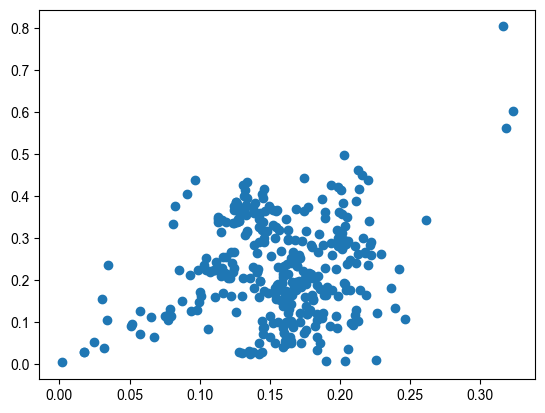

In [349]:
plt.scatter(result['cf_pv'], result['cf_wind'])

In [176]:
result.keys()
dataset = result

In [183]:
dataset.columns

Index(['Country', 'Lag PV Year', 'Lag Wind Year', 'Lag PV Week',
       'Lag Wind Week', 'Lag PV Day', 'Lag Wind Day', 'share_wind', 'share_pv',
       'share_dispatch', 'cf_pv', 'cf_wind', 'corr_load_wind', 'corr_load_pv',
       'beta_year_load', 'max_beta_week_load', 'max_beta_day_load',
       'mean_beta_week_load', 'mean_beta_day_load', 'beta_year_pv',
       'max_beta_week_pv', 'max_beta_day_pv', 'mean_beta_week_pv',
       'mean_beta_day_pv', 'beta_year_wind', 'max_beta_week_wind',
       'max_beta_day_wind', 'mean_beta_week_wind', 'mean_beta_day_wind',
       'scalar_year_pv_load', 'scalar_year_wind_load', 'scalar_day_pv_load',
       'scalar_day_wind_load', 'scalar_week_pv_load', 'scalar_week_wind_load',
       'weight_pv', 'weight_wind', 'State'],
      dtype='object')

### Définition des prédicteurs

In [415]:
# Set de prédicteurs à utiliser dans la suite
X1 = dataset[[ 'cf_pv', 'cf_wind', 'scalar_year_pv_load', 'scalar_year_wind_load', 'scalar_week_pv_load', 'scalar_week_wind_load', 'scalar_day_pv_load', 'scalar_day_wind_load','beta_year_load', 'beta_year_pv', 'beta_year_wind', 'max_beta_week_pv', 'max_beta_week_wind', 'max_beta_day_pv', 'max_beta_day_wind', 'mean_beta_day_wind', 'mean_beta_week_wind','mean_beta_week_pv','mean_beta_day_pv']]
X2 = dataset[[ 'cf_pv', 'cf_wind','scalar_year_pv_load', 'scalar_year_wind_load', 'scalar_week_wind_load', 'scalar_day_pv_load']]
X3 = dataset[[ 'scalar_year_pv_load', 'scalar_year_wind_load', 'scalar_week_pv_load', 'scalar_week_wind_load', 'scalar_day_pv_load', 'scalar_day_wind_load',
              'beta_year_pv', 'beta_year_wind', 'max_beta_week_pv', 'max_beta_week_wind']]
X4 = dataset[[ 'cf_pv', 'cf_wind', 'scalar_year_pv_load', 'scalar_year_wind_load', 'scalar_week_pv_load', 'scalar_week_wind_load', 'scalar_day_pv_load', 'scalar_day_wind_load']]
X5 = dataset[[  'scalar_year_pv_load', 'scalar_year_wind_load', 'scalar_week_pv_load', 'scalar_week_wind_load', 'scalar_day_pv_load', 'scalar_day_wind_load']]
X6 = dataset[dataset.columns.to_list()[1:35]]
X6 = X6.drop(['share_pv', 'share_wind', 'share_dispatch'], axis =1)
X7 = dataset[[ 'cf_pv', 'cf_wind', 'scalar_year_pv_load', 'scalar_year_wind_load', 
               'scalar_day_pv_load', 'scalar_day_wind_load', 'beta_year_pv', 'beta_year_wind','mean_beta_day_wind', 'mean_beta_day_pv', 'max_beta_week_wind', 'mean_beta_week_wind']]
X8 = dataset[['weight_pv', 'weight_wind', 'cf_pv', 'cf_wind', 'scalar_year_pv_load', 'scalar_year_wind_load', 'scalar_week_pv_load', 'scalar_week_wind_load', 'scalar_day_pv_load', 'scalar_day_wind_load','beta_year_load', 'beta_year_pv', 'beta_year_wind', 'max_beta_week_pv', 'max_beta_week_wind', 'max_beta_day_pv', 'max_beta_day_wind', 'mean_beta_day_wind', 'mean_beta_week_wind','mean_beta_week_pv','mean_beta_day_pv']]
X9 = dataset[[ 'scalar_year_pv_load', 'scalar_year_wind_load', 'scalar_week_pv_load', 'scalar_week_wind_load', 'scalar_day_pv_load', 'scalar_day_wind_load','beta_year_load',  'beta_year_wind',  'mean_beta_day_wind', 'mean_beta_week_wind','mean_beta_week_pv','mean_beta_day_pv']]

### Définition des variables à prédire

In [407]:
variable = 'share_pv'

In [409]:
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import os

X = X9


# X = dataset[[ 'Lag PV Year','Lag Wind Year','Lag PV Week', 'Lag Wind Week', 'Lag PV Day', 'Lag Wind Day','cf_pv', 'cf_wind', 'corr_load_wind','corr_load_pv','max_beta_day', 'max_beta_week','beta_year', 'mean_beta_week','mean_beta_day']]
# X = dataset[[ 'Lag PV Year','Lag Wind Year', 'Lag PV Week', 'Lag Wind Week', 'Lag PV Day', 'Lag Wind Day','cf_pv', 'cf_wind', 'max_beta_day', 'max_beta_week', 'beta_year']]
y = dataset[variable]
# print(X.isna().sum())
X_clean = X.dropna()
y = y[X.index.isin(X_clean.index)] 
dataset = dataset[X.index.isin(X_clean.index)] 
X=X_clean # Adjust y accordingly if rows are dropped from X


model = LinearRegression()
model.fit(X, y)
model.score(X, y)  # R²
share_predict = model.predict(X)

coef = model.coef_
a = model.intercept_
dataset['Prediction share Wind'] = share_predict
# Model Evaluation
meanAbErr = metrics.mean_absolute_error(y, share_predict)
meanSqErr = metrics.mean_squared_error(y, share_predict)
rootMeanSqErr = np.sqrt(meanSqErr)

print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print ('RMSE :', rootMeanSqErr)
print(f'Coefficient de détermination (R²): {model.score(X, y)}')

Mean Absolute Error: 5.7607005981120825
Mean Square Error: 58.08565551183099
RMSE : 7.621394591007015
Coefficient de détermination (R²): 0.7863928244819756


On ajoute maintenant les prédicteurs un par un pour voir l'évolution du R2.

In [353]:
# dataset = result
# X = dataset[['cf_wind']]
# y = dataset['share_pv']

# model = LinearRegression()
# model.fit(X, y)
# model.score(X, y)  # R²
# print(model.score(X, y))
# share_predict = model.predict(X)

# coef = model.coef_
# a = model.intercept_

# dataset['Prediction share PV'] = share_predict
# # Model Evaluation
# meanAbErr = metrics.mean_absolute_error(y, share_predict)
# meanSqErr = metrics.mean_squared_error(y, share_predict)
# rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y, share_predict))

# print('Mean Absolute Error:', meanAbErr)
# print('Mean Square Error:', meanSqErr)
# print(f'Coefficient de détermination (R²): {model.score(X, y)}')

# Analyse de la variance

In [410]:
len(X.columns)

13

Coefficients estimés : [ 1.10835028e+01 -1.41610311e-01  3.26479118e+01 -1.94972630e+01
 -1.17074971e-02 -2.40387205e-03  1.35476675e-01  4.30254763e-02
  1.82297304e-03  1.94439211e-03 -2.16126163e+01 -1.89698240e+01
  2.88798087e+01  1.08863165e+01  1.70821825e+00 -1.03637190e+01
  2.65337586e-01 -1.64493963e+01  3.57201812e+01  1.33401182e+01
  2.26806294e+02]
MSE : 6.986397618890479
RMSE : 2.643179452646089
Coefficient de détermination (R^2) : 0.9740596507794919

Analyse de la variance (ANOVA) pour chaque paramètre (variables quantitatives) :


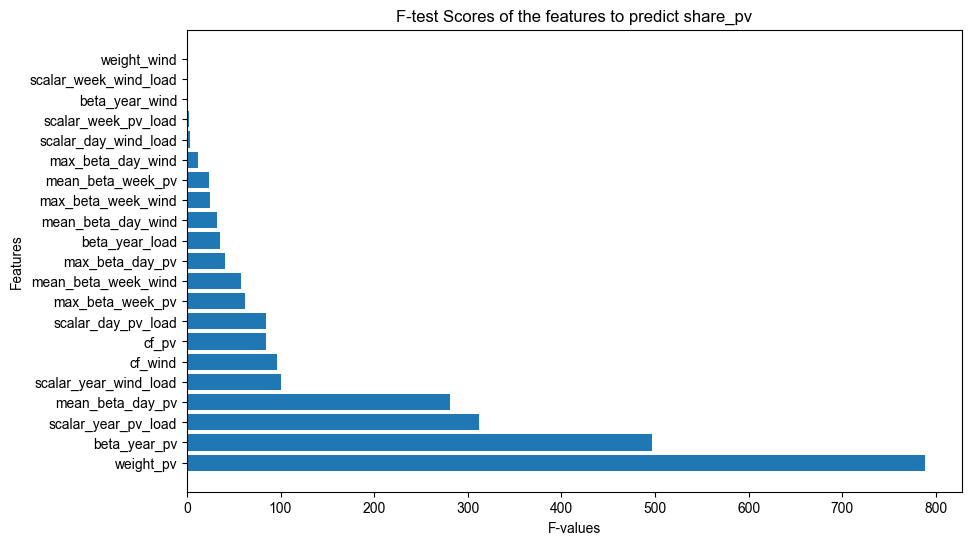

In [400]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression


# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Initialisation du modèle de régression linéaire
model = LinearRegression()

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluation des performances du modèle
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Analyse de la variance (ANOVA) dans le contexte de la régression linéaire
f_values, p_values = f_regression(X, y)

# Affichage des résultats
print("Coefficients estimés :", model.coef_)
print("MSE :", mse)
print("RMSE :",np.sqrt(mse))

print("Coefficient de détermination (R^2) :", r2)
print("\nAnalyse de la variance (ANOVA) pour chaque paramètre (variables quantitatives) :")
# for i, col in enumerate(X.columns):
#     print(f"Paramètre {col}: F-value = {f_values[i]:.2f}, p-value = {p_values[i]:.2e}")

plt.figure(figsize=(10, 6))
indices = np.argsort(f_values)[::-1]
plt.barh(range(X.shape[1]), f_values[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns[indices])
plt.ylabel('Features')
plt.xlabel('F-values')
plt.title(f'F-test Scores of the features to predict {variable}')
plt.show()

# Random Forest

RF train accuracy: 0.966
RF test accuracy: 0.693
Erreur quadratique moyenne (MSE) : 86.61394963524906
RMSE : 9.306661573048043
Coefficient de détermination (R^2) : 0.6930254276560461

Importance des variables :


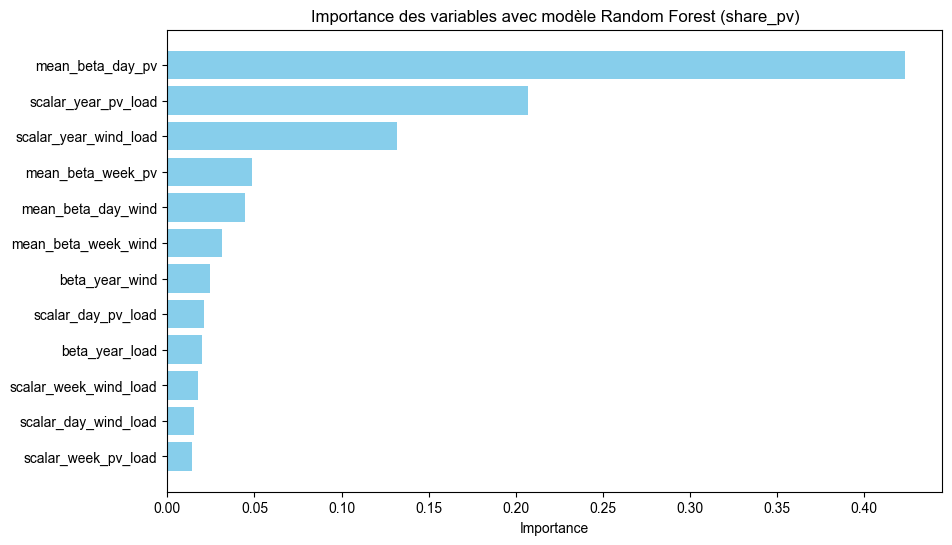

In [417]:
from sklearn.ensemble import RandomForestRegressor
# Séparation des données en ensembles d'entraînement et de test
variable = 'share_pv'
X = dataset[[ 'mean_beta_week_wind', 'max_beta_week_wind','beta_year_wind']]
X = X9
y = dataset[variable]
# print(X.isna().sum())
X_clean = X.dropna()
y = y[X.index.isin(X_clean.index)] 
dataset = dataset[X.index.isin(X_clean.index)] 
X=X_clean # Adjust y accordingly if rows are dropped from X
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialisation du modèle de forêt aléatoire
model = RandomForestRegressor(random_state=42)

# Entraînement du modèle
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"RF train accuracy: {model.score(X_train, y_train):.3f}")
print(f"RF test accuracy: {model.score(X_test, y_test):.3f}")
importances = model.feature_importances_ #impurity-based importance mais 

print("Erreur quadratique moyenne (MSE) :", mse)
print("RMSE :",np.sqrt(mse))
print("Coefficient de détermination (R^2) :", r2)
print("\nImportance des variables :")
# for i, col in enumerate(X.columns):
#     print(f"{col}: Importance = {importances[i]:.4f}")

sorted_idx = importances.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], importances[sorted_idx], color='skyblue')
plt.xlabel('Importance')
plt.title(f'Importance des variables avec modèle Random Forest ({variable})')
plt.show()

Il s'agit ici de l'impurity-based importance. On calcule le MDI = Mean Decrease in Impurity, comme la moyenne des réductions en impureté pour une variable donnée sur tous les arbres de la forêt aléatoire. Impureté de Gini (https://en.wikipedia.org/wiki/Diversity_index#Gini%E2%80%93Simpson_index). Plus MDI est élevé, plus le prédicteur est important. Mais la MDI favorise les variables qui permettent de nombreuses divisions et celles qui ont un cardinal élevé. 

C'est pourquoi on considère aussi la "permutation importance" : https://scikit-learn.org/stable/modules/permutation_importance.html

In [418]:
# Calcul de la matrice de corrélation
correlation_matrix = X.corr()

# Affichage de la matrice de corrélation
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matrice de corrélation des variables indépendantes')
plt.show()

In [419]:
dataset[dataset['Country']=='Djibouti']['beta_year_wind']

40    0.114216
Name: beta_year_wind, dtype: float64

Erreur quadratique moyenne (MSE) : 86.61394963524906
RMSE : 9.306661573048043
Coefficient de détermination (R^2) : 0.6930254276560461

Importance des variables (permutation importance) :
scalar_year_pv_load: Importance moyenne = 0.0690, Ecart-type = 0.0224
scalar_year_wind_load: Importance moyenne = 0.1476, Ecart-type = 0.0423
scalar_week_pv_load: Importance moyenne = 0.0077, Ecart-type = 0.0042
scalar_week_wind_load: Importance moyenne = 0.0043, Ecart-type = 0.0078
scalar_day_pv_load: Importance moyenne = 0.0132, Ecart-type = 0.0042
scalar_day_wind_load: Importance moyenne = -0.0003, Ecart-type = 0.0032
beta_year_load: Importance moyenne = 0.0020, Ecart-type = 0.0040
beta_year_wind: Importance moyenne = 0.0087, Ecart-type = 0.0091
mean_beta_day_wind: Importance moyenne = 0.0614, Ecart-type = 0.0132
mean_beta_week_wind: Importance moyenne = 0.0107, Ecart-type = 0.0088
mean_beta_week_pv: Importance moyenne = 0.0287, Ecart-type = 0.0167
mean_beta_day_pv: Importance moyenne = 0.5360, Ecar

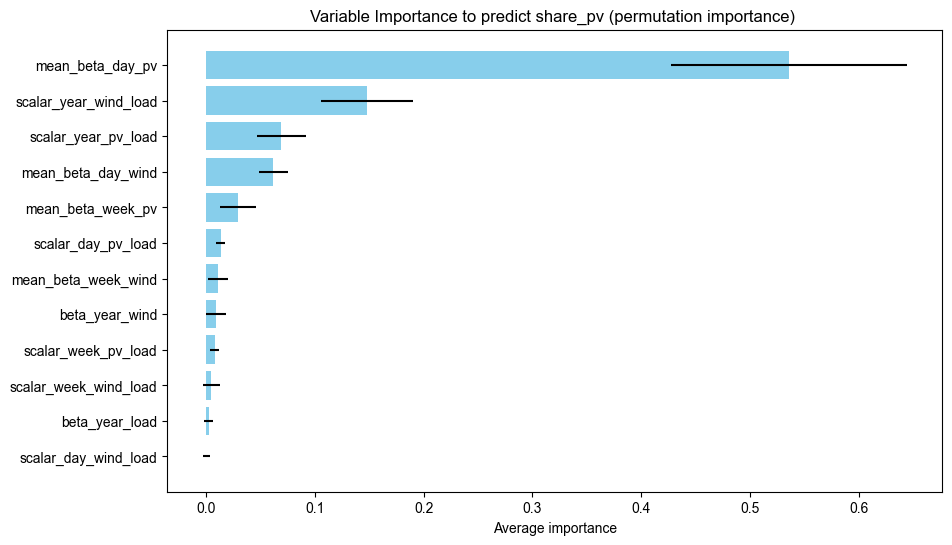

In [420]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)

print("Erreur quadratique moyenne (MSE) :", mse)
print("RMSE :",np.sqrt(mse))
print("Coefficient de détermination (R^2) :", r2)
print("\nImportance des variables (permutation importance) :")
for i, col in enumerate(X.columns):
    print(f"{col}: Importance moyenne = {result.importances_mean[i]:.4f}, Ecart-type = {result.importances_std[i]:.4f}")


sorted_idx = result.importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], result.importances_mean[sorted_idx], xerr=result.importances_std[sorted_idx], color='skyblue')
plt.xlabel('Average importance')
plt.title(f'Variable Importance to predict {variable} (permutation importance) ')
plt.show()

# K-fold Cross Validation

On met en place un K-fold cross-validation

In [59]:
y

0      69.240357
1      57.709340
2      29.751267
3      73.275992
5      20.749224
         ...    
174    53.822427
175    53.684775
176    54.016967
177    45.548838
178    58.773745
Name: share_pv, Length: 331, dtype: float64

Erreur quadratique moyenne (MSE) moyenne : 52.78115176827172
RMSE moyen: 7.265063782808222
Coefficient de détermination (R^2) moyen: 0.8069210106699032

Importance des variables (permutation importance) moyenne :
Lag PV Year: Importance moyenne = -0.0003, Ecart-type = 0.0012
Lag Wind Year: Importance moyenne = 0.0015, Ecart-type = 0.0029
Lag PV Week: Importance moyenne = -0.0002, Ecart-type = 0.0012
Lag Wind Week: Importance moyenne = -0.0003, Ecart-type = 0.0013
Lag PV Day: Importance moyenne = 0.0005, Ecart-type = 0.0015
Lag Wind Day: Importance moyenne = 0.0021, Ecart-type = 0.0018
cf_pv: Importance moyenne = 0.0240, Ecart-type = 0.0094
cf_wind: Importance moyenne = 0.1806, Ecart-type = 0.0443
corr_load_wind: Importance moyenne = 0.0096, Ecart-type = 0.0055
corr_load_pv: Importance moyenne = 0.0009, Ecart-type = 0.0030
beta_year_load: Importance moyenne = -0.0005, Ecart-type = 0.0016
max_beta_week_load: Importance moyenne = -0.0003, Ecart-type = 0.0028
max_beta_day_load: Importance 

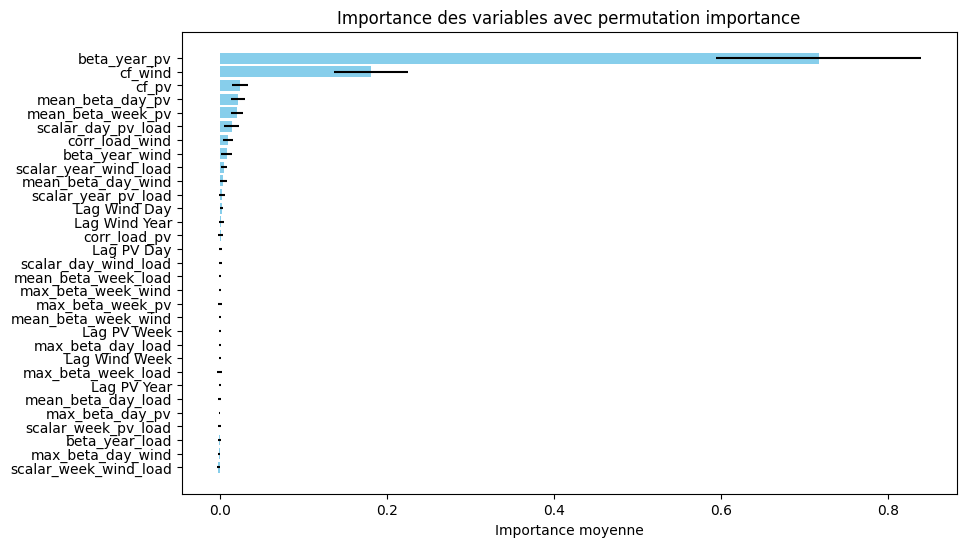

In [109]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score


# Initialize the RandomForestRegressor with a fixed random state
model = RandomForestRegressor(random_state=0)

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=0)

mse_scores = []
r2_scores = []
perm_importance_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate MSE and R^2 scores
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    # Permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)
    perm_importance_results.append(result)

# Average MSE and R^2 across folds
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)

print("Erreur quadratique moyenne (MSE) moyenne :", avg_mse)
print("RMSE moyen:", np.sqrt(avg_mse))
print("Coefficient de détermination (R^2) moyen:", avg_r2)

# Average permutation importance results
importances_mean = np.mean([result.importances_mean for result in perm_importance_results], axis=0)
importances_std = np.mean([result.importances_std for result in perm_importance_results], axis=0)

print("\nImportance des variables (permutation importance) moyenne :")
for i, col in enumerate(X.columns):
    print(f"{col}: Importance moyenne = {importances_mean[i]:.4f}, Ecart-type = {importances_std[i]:.4f}")

# Plot average permutation importance
sorted_idx = importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx], importances_mean[sorted_idx], xerr=importances_std[sorted_idx], color='skyblue')
plt.xlabel('Importance moyenne')
plt.title('Importance des variables avec permutation importance')
plt.show()


In [61]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


# Tentative de tuning des hyperparameters

On tente d'implémenter la méthode décrite ici : https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [26]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [27]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


C:\Users\JD278300\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
123 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
56 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JD278300\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JD278300\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "C:\Users\JD278300\AppData\Roaming\Python\Python310\site-packages\sklearn\base.py", line 666, in _validate_para

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [28]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': False}

In [31]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f}.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestRegressor(random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))


Model Performance
Average Error: 6.4064.
Accuracy = 83.59%.
Model Performance
Average Error: 6.4628.
Accuracy = 82.71%.
Improvement of -1.04%.


On obtient cependant un modèle moins performant... Peut-être que c'est parce que la procédure n'a pas pu utiliser les 300 fits prévus.

# Gradient Boosting

Mean Absolute Error: 0.5610323917862985
Mean Square Error: 0.8400974467943323
RMSE : 0.9165682990341376
Coefficient de détermination (R^2) : 0.406687320515017


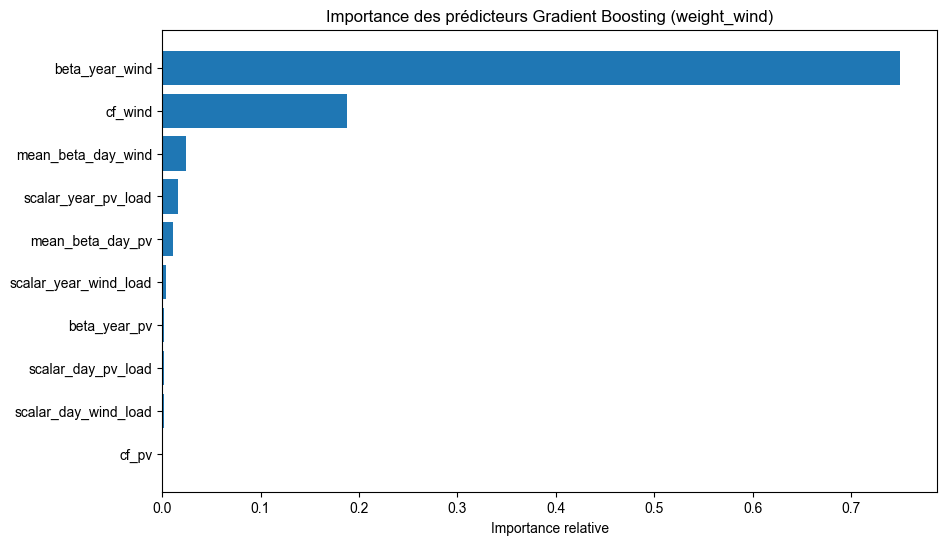

In [318]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

meanSqErr = mean_squared_error(y_test, y_pred)
meanAbErr = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rootMeanSqErr = np.sqrt(meanSqErr)

print('Mean Absolute Error:', meanAbErr)
print('Mean Square Error:', meanSqErr)
print ('RMSE :', rootMeanSqErr)
print("Coefficient de détermination (R^2) :", r2)
importances = model.feature_importances_



indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title(f"Importance des prédicteurs Gradient Boosting ({variable})")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), X.columns[sorted_idx])
plt.xlabel("Importance relative")
plt.show()

## K-fold cross-validation

Erreur quadratique moyenne (MSE) moyenne : 50.36993468127861
RMSE moyen: 7.097177937834066
Coefficient de détermination (R^2) moyen: 0.8109461100968302

Importance des variables (permutation importance) moyenne :
Lag PV Year: Importance moyenne = 0.0055, Ecart-type = 0.0042
Lag Wind Year: Importance moyenne = 0.0014, Ecart-type = 0.0041
Lag PV Week: Importance moyenne = -0.0005, Ecart-type = 0.0047
Lag Wind Week: Importance moyenne = 0.0001, Ecart-type = 0.0050
Lag PV Day: Importance moyenne = 0.0016, Ecart-type = 0.0062
Lag Wind Day: Importance moyenne = 0.0016, Ecart-type = 0.0031
share_dispatch: Importance moyenne = 0.0543, Ecart-type = 0.0189
cf_pv: Importance moyenne = 0.1487, Ecart-type = 0.0336
cf_wind: Importance moyenne = 0.3163, Ecart-type = 0.0549
corr_load_wind: Importance moyenne = 0.0164, Ecart-type = 0.0107
corr_load_pv: Importance moyenne = 0.0245, Ecart-type = 0.0103
beta_year_load: Importance moyenne = 0.0133, Ecart-type = 0.0070
max_beta_week_load: Importance moyenne

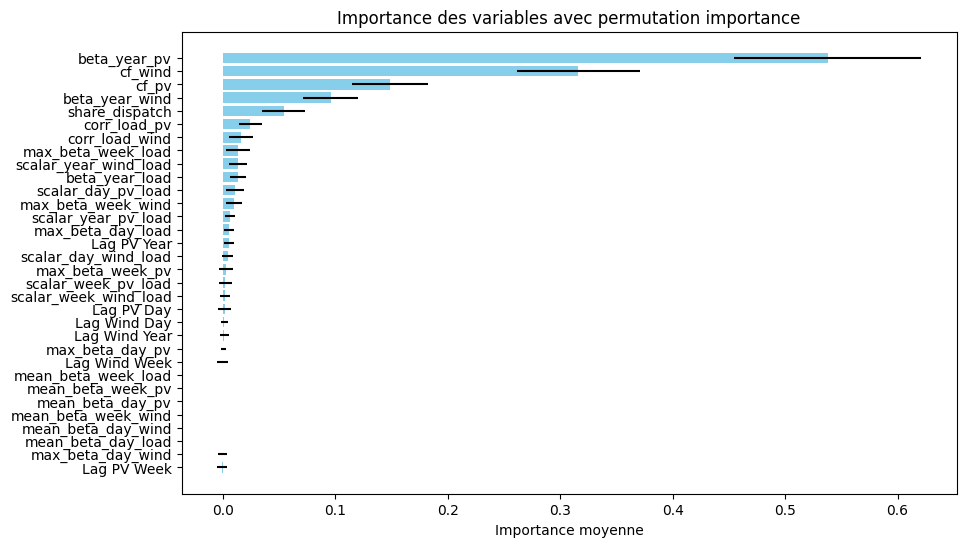

In [63]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score


# Initialize the RandomForestRegressor with a fixed random state
model = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=42)

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

mse_scores = []
r2_scores = []
perm_importance_results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate MSE and R^2 scores
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    mse_scores.append(mse)
    r2_scores.append(r2)
    
    # Permutation importance
    result = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)
    perm_importance_results.append(result)

# Average MSE and R^2 across folds
avg_mse = np.mean(mse_scores)
avg_r2 = np.mean(r2_scores)

print("Erreur quadratique moyenne (MSE) moyenne :", avg_mse)
print("RMSE moyen:", np.sqrt(avg_mse))
print("Coefficient de détermination (R^2) moyen:", avg_r2)

# Average permutation importance results
importances_mean = np.mean([result.importances_mean for result in perm_importance_results], axis=0)
importances_std = np.mean([result.importances_std for result in perm_importance_results], axis=0)

print("\nImportance des variables (permutation importance) moyenne :")
for i, col in enumerate(X.columns):
    print(f"{col}: Importance moyenne = {importances_mean[i]:.4f}, Ecart-type = {importances_std[i]:.4f}")

# Plot average permutation importance
sorted_idx = importances_mean.argsort()
plt.figure(figsize=(10, 6))
plt.barh(np.array(X.columns)[sorted_idx], importances_mean[sorted_idx], xerr=importances_std[sorted_idx], color='skyblue')
plt.xlabel('Importance moyenne')
plt.title('Importance des variables avec permutation importance')
plt.show()


# PCA

In [270]:
from sklearn.decomposition import PCA

In [271]:
X

,scalar_year_pv_load,scalar_year_wind_load,scalar_week_pv_load,scalar_week_wind_load,scalar_day_pv_load,scalar_day_wind_load,beta_year_pv,beta_year_wind,max_beta_week_pv,max_beta_week_wind,mean_beta_week_pv,mean_beta_week_wind,mean_beta_day_wind,mean_beta_day_pv
1,2.345717,-9.542519,-0.399951,2.127037,282.352946,8.484847,0.043508,0.056401,0.076372,0.163145,-3.041707e-19,-3.041707e-19,6.178467e-20,-8.554801e-20
2,-23.186931,89.346480,-0.153099,12.802202,217.533214,-116.551359,0.005495,0.045814,0.057642,0.218375,-2.376334e-20,-7.604267e-20,6.653734e-20,-3.802134e-20
3,-21.795265,-52.225175,0.276485,3.482418,122.482914,-20.477895,0.035439,0.082970,0.029977,0.180181,-1.901067e-20,1.520853e-19,-1.901067e-19,-3.326867e-20
5,18.941197,15.431592,-0.710058,-3.904103,80.262477,26.394178,0.043056,0.033950,0.038127,0.132153,4.752667e-20,3.041707e-19,1.425800e-19,-1.806013e-19
6,-17.352064,15.851159,-0.654684,-1.461134,210.234439,56.133774,0.025199,0.042992,0.063113,0.187125,1.710960e-19,6.178467e-19,-5.703200e-20,-1.544617e-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,12.790045,2.565645,0.826317,18.513933,136.915385,37.371779,0.030043,0.074385,0.102583,0.172735,2.281280e-19,-6.083414e-19,9.030067e-20,-3.231814e-19
175,0.605022,-11.770488,0.949249,-7.653455,162.500872,33.539050,0.031320,0.060408,0.071985,0.201468,1.901067e-19,1.520853e-19,2.566440e-19,-4.942774e-19
176,5.314329,0.179589,-5.987403,4.817145,163.497703,-17.867299,0.013394,0.063130,0.066231,0.143680,-1.901067e-19,3.802134e-19,-1.235693e-19,-4.467507e-19
177,0.531710,-2.523788,-1.784192,4.429942,168.243036,-29.224245,0.031033,0.023705,0.060174,0.235301,-7.604267e-20,3.802134e-20,-2.091174e-19,1.330747e-19


Variance expliquée par chaque composante principale: [0.67967225 0.21039571 0.070298   0.03839281]
Composantes principales (PCA) :
   scalar_year_pv_load  scalar_year_wind_load  scalar_week_pv_load  \
0             0.216529              -0.387838            -0.000377   
1             0.026531              -0.914664             0.001703   
2            -0.965374              -0.105978            -0.002316   
3             0.142561               0.041701            -0.000831   

   scalar_week_wind_load  scalar_day_pv_load  scalar_day_wind_load  \
0              -0.002427            0.894269             -0.054539   
1              -0.000823           -0.403324             -0.003532   
2               0.011574            0.178185             -0.157899   
3               0.000519           -0.076561             -0.985938   

   beta_year_pv  beta_year_wind  max_beta_week_pv  max_beta_week_wind  \
0     -0.000074       -0.000003         -0.000040           -0.000093   
1     -0.000043      

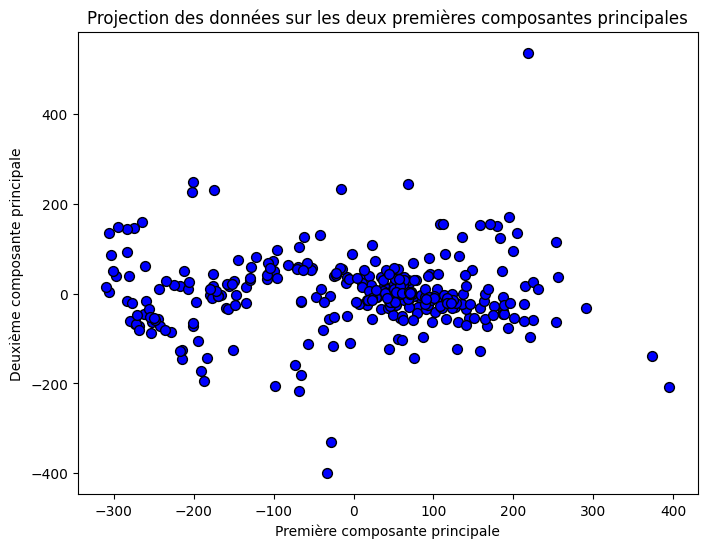

In [273]:
# Initialiser la PCA
pca = PCA(n_components=4)  # On souhaite réduire les données à 2 composantes principales

# Ajuster la PCA sur les données
X_pca = pca.fit_transform(X)

# Afficher les pourcentages de variance expliquée par chaque composante principale
print('Variance expliquée par chaque composante principale:', pca.explained_variance_ratio_)

# Afficher les composantes principales
components_df = pd.DataFrame(pca.components_, columns=X.columns)
print("Composantes principales (PCA) :")
print(components_df)

# Afficher la variance expliquée par chaque composante principale
explained_variance_ratio = pca.explained_variance_ratio_
print("\nVariance expliquée par chaque composante principale :")
for i, ratio in enumerate(explained_variance_ratio):
    print(f"Composante {i+1}: {ratio:.4f}")

# Plot des résultats PCA
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c='blue', edgecolor='k', s=50)
plt.xlabel('Première composante principale')
plt.ylabel('Deuxième composante principale')
plt.title('Projection des données sur les deux premières composantes principales')
plt.show()

In [71]:
len(y)

331

In [252]:
perf = pd.read_excel('results/performance_modeles_v3.xlsx', sheet_name = 'Set 1')
perf

,Modèle,Variable cible,RMSE,R2
0,Régression linéaire multiple,% Wind,6.200,0.865
1,Random Forest,NaN,8.250,0.760
2,Gradient Boosting,NaN,6.040,0.761
3,Régression linéaire multiple,% PV,4.550,0.876
4,Random Forest,NaN,7.260,0.804
5,Gradient Boosting,NaN,4.790,0.850
6,Régression linéaire multiple,PV Weight,0.460,0.749
7,Random Forest,NaN,0.523,0.670
8,Gradient Boosting,NaN,0.431,0.724
9,Régression linéaire multiple,Wind Weight,2.230,0.420


In [253]:
def r2_ajuste(r2, n, k):
    """
    Calcule le R^2 ajusté.
    
    Paramètres:
    r2 (float): Le coefficient de détermination non ajusté.
    n (int): Le nombre total d'observations.
    k (int): Le nombre de prédicteurs dans le modèle.
    
    Retourne:
    float: Le R^2 ajusté.
    """
    return 1 - ((1 - r2) * (n - 1)) / (n - k - 1)

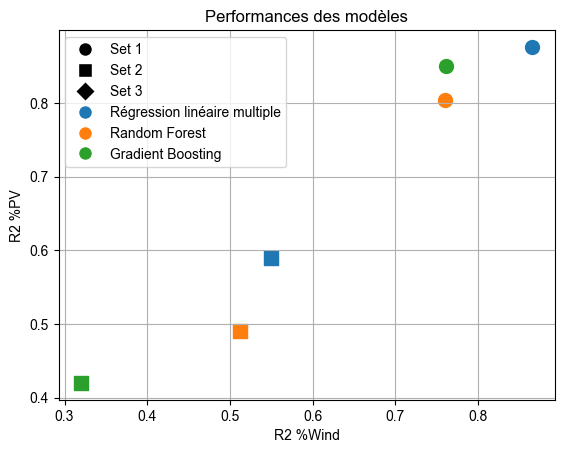

In [254]:
import matplotlib.pyplot as plt

# Données
modeles = ['Régression linéaire multiple', 'Random Forest', 'Gradient Boosting']
perf1 = pd.read_excel('results/performance_modeles_v3.xlsx', sheet_name = 'Set 1')
perf2 = pd.read_excel('results/performance_modeles_v3.xlsx', sheet_name = 'Set 2')
perf3 = pd.read_excel('results/performance_modeles_v3.xlsx', sheet_name = 'Set 4')
R2_Wind_set1 = perf1['R2'].to_list()[:3]
R2_PV_set1 =perf1['R2'].to_list()[3:]
R2_Wind_set2 = perf2['R2'].to_list()[:3]
R2_PV_set2 = perf2['R2'].to_list()[3:]
R2_Wind_set3 = perf3['R2'].to_list()[:3]
R2_PV_set3 = perf3['R2'].to_list()[3:]

# Couleurs et formes différentes pour chaque modèle et set
couleurs = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Bleu, orange, vert
formes = ['o', 's', 'D']  # 'o' pour cercle, 's' pour carré, 'D' pour diamant
plt.rcParams['font.family'] = 'Arial'
# Création de la figure et des axes
fig, ax = plt.subplots()

# Fonction pour plotter les points
def plot_points(R2_Wind, R2_PV, forme):
    for i, modele in enumerate(modeles):
        ax.scatter(R2_Wind[i], R2_PV[i], color=couleurs[i], marker=forme, s=100)

# Plotter les points pour chaque set de prédicteurs
plot_points(R2_Wind_set1, R2_PV_set1, formes[0])
plot_points(R2_Wind_set2, R2_PV_set2, formes[1])
plot_points(R2_Wind_set3, R2_PV_set3, formes[2])

# Ajouter des labels et un titre
ax.set_xlabel('R2 %Wind')
ax.set_ylabel('R2 %PV')
ax.set_title('Performances des modèles')

# Création de légendes personnalisées
from matplotlib.lines import Line2D

# Légende pour les formes (sets de prédicteurs)
formes_legende = [Line2D([0], [0], marker=formes[i], color='w', label=f'Set {i+1}', markerfacecolor='black', markersize=10) for i in range(len(formes))]

# Légende pour les couleurs (modèles)
couleurs_legende = [Line2D([0], [0], marker='o', color='w', label=modeles[i], markerfacecolor=couleurs[i], markersize=10) for i in range(len(couleurs))]

# Afficher les légendes
ax.legend(handles=formes_legende + couleurs_legende, loc='upper left')

# Afficher le graphique
plt.grid(True)
plt.show()

In [260]:
perf1

,Modèle,Variable cible,RMSE,R2
0,Régression linéaire multiple,% Wind,NaN,0.799
1,Random Forest,NaN,9.12,0.707
2,Gradient Boosting,NaN,7.81,0.662
3,Régression linéaire multiple,% PV,5.46,0.890
4,Random Forest,NaN,7.44,0.790
5,Gradient Boosting,NaN,4.85,0.850


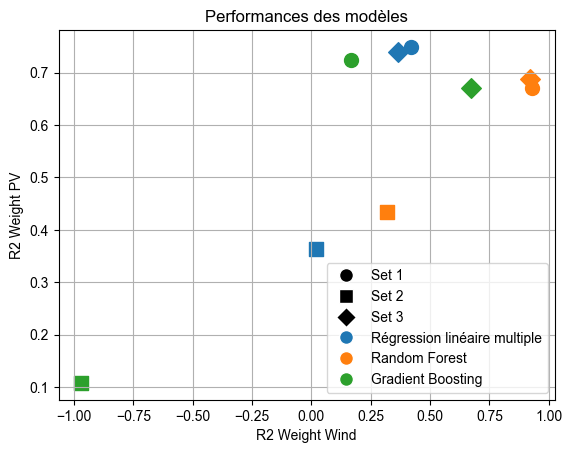

In [308]:

# Données
modeles = ['Régression linéaire multiple', 'Random Forest', 'Gradient Boosting']
perf1 = pd.read_excel('results/performance_modeles_v3.xlsx', sheet_name = 'Set 1')
perf2 = pd.read_excel('results/performance_modeles_v3.xlsx', sheet_name = 'Set 2')
perf3 = pd.read_excel('results/performance_modeles_v3.xlsx', sheet_name = 'Set 4')
R2_Wind_set1 = perf1['R2'].to_list()[9:]
R2_PV_set1 =perf1['R2'].to_list()[6:9]
R2_Wind_set2 = perf2['R2'].to_list()[9:]
R2_PV_set2 = perf2['R2'].to_list()[6:9]
R2_Wind_set4 = perf3['R2'].to_list()[9:]
R2_PV_set4 = perf3['R2'].to_list()[6:9]
# print(R2_Wind_set1)
# Couleurs et formes différentes pour chaque modèle et set
couleurs = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Bleu, orange, vert
formes = ['o', 's', 'D']  # 'o' pour cercle, 's' pour carré, 'D' pour diamant
plt.rcParams['font.family'] = 'Arial'
# Création de la figure et des axes
fig, ax = plt.subplots()

# Fonction pour plotter les points
def plot_points(R2_Wind, R2_PV, forme):
    for i, modele in enumerate(modeles):
        ax.scatter(R2_Wind[i], R2_PV[i], color=couleurs[i], marker=forme, s=100)

# Plotter les points pour chaque set de prédicteurs
plot_points(R2_Wind_set1, R2_PV_set1, formes[0])
plot_points(R2_Wind_set2, R2_PV_set2, formes[1])
plot_points(R2_Wind_set4, R2_PV_set4, formes[2])

# Ajouter des labels et un titre
ax.set_xlabel('R2 Weight Wind')
ax.set_ylabel('R2 Weight PV')
ax.set_title('Performances des modèles')

# Création de légendes personnalisées
from matplotlib.lines import Line2D

# Légende pour les formes (sets de prédicteurs)
formes_legende = [Line2D([0], [0], marker=formes[i], color='w', label=f'Set {i+1}', markerfacecolor='black', markersize=10) for i in range(len(formes))]

# Légende pour les couleurs (modèles)
couleurs_legende = [Line2D([0], [0], marker='o', color='w', label=modeles[i], markerfacecolor=couleurs[i], markersize=10) for i in range(len(couleurs))]

# Afficher les légendes
ax.legend(handles=formes_legende + couleurs_legende, loc='lower right')

# Afficher le graphique
plt.grid(True)
plt.show()

In [273]:
perf2

,Modèle,Variable cible,RMSE,R2
0,Régression linéaire multiple,% Wind,11.260,0.550
1,Random Forest,NaN,11.800,0.512
2,Gradient Boosting,NaN,11.400,0.320
3,Régression linéaire multiple,% PV,10.400,0.590
4,Random Forest,NaN,12.000,0.490
5,Gradient Boosting,NaN,10.400,0.420
6,Régression linéaire multiple,PV Weight,0.730,0.363
7,Random Forest,NaN,0.685,0.434
8,Gradient Boosting,NaN,NaN,0.108
9,Régression linéaire multiple,Wind Weight,NaN,0.018


In [271]:
R2_PV_set3

[0.74, 0.688, 0.0]

In [80]:
import matplotlib.pyplot as plt

# Données
modeles = ['Régression linéaire multiple', 'Random Forest', 'Gradient Boosting']
perf1 = pd.read_excel('results/performance_modeles_v3.xlsx', sheet_name = 'Set 1')
perf2 = pd.read_excel('results/performance_modeles_v3.xlsx', sheet_name = 'Set 2')
perf3 = pd.read_excel('results/performance_modeles_v3.xlsx', sheet_name = 'Set 4')
R2_Wind_set1 = perf1['R2'].to_list()[:3]
R2_PV_set1 =perf1['R2'].to_list()[3:]
R2_Wind_set2 = perf2['R2'].to_list()[:3]
R2_PV_set2 = perf2['R2'].to_list()[3:]
R2_Wind_set3 = perf3['R2'].to_list()[:3]
R2_PV_set3 = perf3['R2'].to_list()[3:]

# Couleurs et formes différentes pour chaque modèle et set
couleurs = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Bleu, orange, vert
formes = ['o', 's', 'D']  # 'o' pour cercle, 's' pour carré, 'D' pour diamant
plt.rcParams['font.family'] = 'Arial'
# Création de la figure et des axes
fig, ax = plt.subplots()

# Fonction pour plotter les points
def plot_points(R2_Wind, R2_PV, forme):
    for i, modele in enumerate(modeles):
        ax.scatter(R2_Wind[i], R2_PV[i], color=couleurs[i], marker=forme, s=100)

# Plotter les points pour chaque set de prédicteurs
plot_points(R2_Wind_set1, R2_PV_set1, formes[0])
plot_points(R2_Wind_set2, R2_PV_set2, formes[1])
plot_points(R2_Wind_set3, R2_PV_set3, formes[2])

# Ajouter des labels et un titre
ax.set_xlabel('R2 %Wind')
ax.set_ylabel('R2 %PV')
ax.set_title('Performances des modèles')

# Création de légendes personnalisées
from matplotlib.lines import Line2D

# Légende pour les formes (sets de prédicteurs)
formes_legende = [Line2D([0], [0], marker=formes[i], color='w', label=f'Set {i+1}', markerfacecolor='black', markersize=10) for i in range(len(formes))]

# Légende pour les couleurs (modèles)
couleurs_legende = [Line2D([0], [0], marker='o', color='w', label=modeles[i], markerfacecolor=couleurs[i], markersize=10) for i in range(len(couleurs))]

# Afficher les légendes
ax.legend(handles=formes_legende + couleurs_legende, loc='upper left')

# Afficher le graphique
plt.grid(True)
plt.show()

,cf_pv,cf_wind,scalar_year_pv_load,scalar_year_wind_load,scalar_week_pv_load,scalar_week_wind_load,scalar_day_pv_load,scalar_day_wind_load,beta_year_pv,beta_year_wind,max_beta_week_pv,max_beta_week_wind,max_beta_day_pv,max_beta_day_wind
0,0.246219,0.107786,33.518409,88.373150,-0.252315,-0.252315,104.518736,16.398379,0.012511,0.046828,0.082383,0.150334,0.309949,0.298244
1,0.174821,0.159912,2.345717,-9.542519,-0.399951,-0.399951,282.352946,8.484847,0.043508,0.056401,0.076372,0.163145,0.280680,0.221042
2,0.213016,0.461972,-23.186931,89.346480,-0.153099,-0.153099,217.533214,-116.551359,0.005495,0.045814,0.057642,0.218375,0.272562,0.305831
3,0.185640,0.179414,-21.795265,-52.225175,0.276485,0.276485,122.482914,-20.477895,0.035439,0.082970,0.029977,0.180181,0.270019,0.187889
5,0.189089,0.361690,18.941197,15.431592,-0.710058,-0.710058,80.262477,26.394178,0.043056,0.033950,0.038127,0.132153,0.273013,0.217152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,0.165921,0.240205,12.790045,2.565645,0.826317,18.513933,136.915385,37.371779,0.030043,0.074385,0.102583,0.172735,0.321897,0.379624
175,0.079037,0.131707,0.605022,-11.770488,0.949249,-7.653455,162.500872,33.539050,0.031320,0.060408,0.071985,0.201468,0.330253,0.297053
176,0.201463,0.274841,5.314329,0.179589,-5.987403,4.817145,163.497703,-17.867299,0.013394,0.063130,0.066231,0.143680,0.288203,0.306898
177,0.132283,0.306882,0.531710,-2.523788,-1.784192,4.429942,168.243036,-29.224245,0.031033,0.023705,0.060174,0.235301,0.302814,0.368193


# Sélection des indicateurs

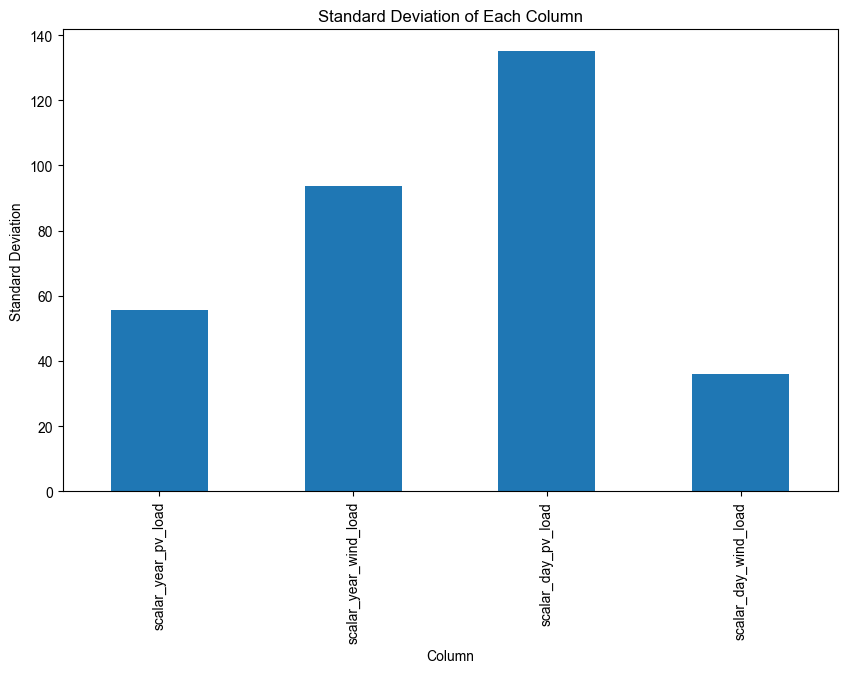

In [377]:
# Calculate the standard deviation for each column except the 'Country' column
std_devs = dataset[['scalar_year_pv_load', 'scalar_year_wind_load', 'scalar_day_pv_load', 'scalar_day_wind_load']].std()

# Plot the standard deviations
plt.figure(figsize=(10, 6))
std_devs.plot(kind='bar')
plt.title('Standard Deviation of Each Column')
plt.xlabel('Column')
plt.ylabel('Standard Deviation')
plt.xticks(rotation=90)
plt.show()

In [379]:
dataset.sort_values(by = 'scalar_year_pv_load')

,Country,Lag PV Year,Lag Wind Year,Lag PV Week,Lag Wind Week,Lag PV Day,Lag Wind Day,share_wind,share_pv,share_dispatch,...,scalar_year_pv_load,scalar_year_wind_load,scalar_day_pv_load,scalar_day_wind_load,scalar_week_pv_load,scalar_week_wind_load,weight_pv,weight_wind,State,Prediction share Wind
40,Djibouti,11701,12655,138,325,11,8,11.910766,67.275685,20.813549,...,-236.630895,-580.559593,85.273278,22.973394,-0.832490,-0.832490,4.268700,0.512795,NaN,63.145612
112,Russia,13931,8262,23,73,22,11,40.180461,35.947029,23.872510,...,-190.987465,-43.064699,-44.434230,3.836240,-1.337758,4.553416,4.042292,3.130922,SA,30.041652
135,Sweden,12935,14170,57,72,9,11,66.536161,15.293257,18.170582,...,-176.874316,-19.604888,62.792917,5.215810,1.666389,1.666389,1.746009,3.693707,NaN,20.888313
132,Russia,12763,505,219,56,27,12,68.328913,15.643658,16.027429,...,-173.466225,73.396206,-91.609567,8.064568,-1.798265,1.444386,1.694939,3.636333,VLG,19.549696
69,Russia,13929,497,38,112,25,16,64.715245,17.220404,18.064350,...,-170.120363,104.151729,-57.281605,0.140702,-0.331163,-2.053987,2.096066,4.619260,CHU,26.884266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,Jordan,1356,3641,332,49,12,15,45.882575,44.366040,9.751385,...,43.726110,60.272911,116.235677,13.108979,0.223080,0.223080,2.230387,1.491516,NaN,50.390026
82,Lebanon,1036,12659,267,135,11,9,11.104299,75.532632,13.363070,...,56.990234,-136.256863,114.016894,3.872273,-0.961017,-0.961017,4.129713,1.005098,NaN,82.803715
37,Cyprus,1040,11676,111,53,18,10,23.419106,63.566159,13.014734,...,59.239752,-172.369036,-69.575098,31.585937,-0.838104,-0.838104,3.547355,0.916286,NaN,69.202854
78,Kuwait,118,1319,202,147,10,22,37.949828,48.879988,13.170184,...,64.835649,418.363114,161.173662,-39.488152,0.761522,0.761522,2.807021,1.056328,NaN,52.886619
